# Reproducing Neuron analysis (Fig. 5A,B):
- Set `DATA_PATH` to your local `scDRS_data_release_030122` folder (see below)
- The provided data files are located at `${DATA_PATH}/single_cell_data/zeisel_2015`
- The provided cell scores are located at `${DATA_PATH}/score_file/score.zeisel_2015`
- Alternatively curate the data using `job.curate_data/curate_zeisel_2015.ipynb`
- Alternatively compute the scores using the following scripts

## Revision history
1. Gene sets updated with continuous weights (from MAGMA z-score)
2. Score files updated correspondingly.

```bash
DATA_PATH=/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_030122
ROOT_PATH=${DATA_PATH}/single_cell_data/zeisel_2015
mkdir -p ${DATA_PATH}/score_file/score.zeisel_2015

scdrs compute-score \
    --h5ad-file ${ROOT_PATH}/expr.h5ad \
    --h5ad-species mouse \
    --gs-file ${ROOT_PATH}/geneset.gs \
    --gs-species mouse \
    --cov-file ${ROOT_PATH}/cov.tsv \
    --flag-filter True \
    --flag-raw-count True \
    --flag-return-ctrl-raw-score False \
    --flag-return-ctrl-norm-score True \
    --out-folder ${DATA_PATH}/score_file/score.zeisel_2015
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import matplotlib.pyplot as plt
import os
from os.path import join
from IPython.display import display, Markdown, Latex
import sys
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import scanpy as sc
from scipy.stats import pearsonr
from toolz import interleave

In [2]:
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data_release_030122"

In [3]:
# Set file paths
DF_TRAIT_INFO = pd.read_csv(DATA_PATH + "/supp_table/trait_info.tsv", sep="\t")
DF_TRAIT_INFO.index = DF_TRAIT_INFO["Trait_Identifier"]

# Set score file
SCORE_PATH = join(DATA_PATH, "score_file/score.zeisel_2015")
# Set trait list
TRAIT_LIST = [
    "PASS_MDD_Howard2019",
    "PASS_Schizophrenia_Pardinas2018",
    "PASS_BIP_Mullins2021",
    "UKB_460K.mental_NEUROTICISM",
    "UKB_460K.cov_SMOKING_STATUS",
    "UKB_460K.cov_EDU_COLLEGE",
    "UKB_460K.body_BMIz",
    "UKB_460K.body_HEIGHTz",
]

DICT_TRAIT_CODE = {
    row["Trait_Identifier"]: row["Code"] for _, row in DF_TRAIT_INFO.iterrows()
}

# Perform regression analysis

In [4]:
adata = sc.read_h5ad(join(DATA_PATH, "single_cell_data/zeisel_2015/expr.h5ad"))
adata = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])].copy()

spatial_cols = [
    "spatial_ventral",
    "spatial_dorsal",
    "spatial_distal",
    "spatial_proximal",
    "spatial_deep",
    "spatial_superficial",
]

df_list = []
for spatial_col in spatial_cols:
    temp_df = pd.read_csv(
        join(SCORE_PATH, f"{spatial_col}.score.gz"),
        sep="\t",
        index_col=0,
    )
    temp_df.columns = ["%s.%s" % (spatial_col, x) for x in temp_df.columns]
    df_list.append(temp_df)

df_spatial_score = pd.concat(df_list, axis=1)
df_spatial_score = df_spatial_score[
    [col for col in df_spatial_score if col.endswith(".norm_score")]
].rename(columns=lambda c: c[:-11])

for spatial_col in df_spatial_score.columns:
    adata.obs[spatial_col] = df_spatial_score[spatial_col].reindex(adata.obs.index)

spatial_cols = [col for col in adata.obs.columns if col.startswith("spatial_")]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
dict_reg_rls = {}
n_ctrl = 1000

for trait in TRAIT_LIST:
    print(trait)
    df_trait_score = pd.read_csv(
        join(SCORE_PATH, f"{trait}.full_score.gz"), sep="\t", index_col=0
    )

    for col in ["norm_score"] + [f"ctrl_norm_score_{i}" for i in range(n_ctrl)]:
        adata.obs[col] = df_trait_score[col].reindex(adata.obs.index)

    dict_tstats = dict()
    dict_ctrl_tstats = {col: np.zeros(n_ctrl) for col in spatial_cols}

    for spatial_col in spatial_cols:
        # regression results for `spatial_col`
        exog = pd.DataFrame(adata.obs[spatial_col])
        exog.insert(0, "const", 1)
        rls = sm.OLS(
            adata.obs["norm_score"],
            exog,
        ).fit()
        dict_tstats[spatial_col] = rls.tvalues[spatial_col]

        # calculate control statistics
        for i_ctrl in range(n_ctrl):
            rls = sm.OLS(
                adata.obs[f"ctrl_norm_score_{i_ctrl}"],
                exog,
            ).fit()
            dict_ctrl_tstats[spatial_col][i_ctrl] = rls.tvalues[spatial_col]

    dict_rls = dict()
    for spatial_col in spatial_cols:
        tstats = dict_tstats[spatial_col]
        ctrl_tstats = dict_ctrl_tstats[spatial_col]
        dict_rls[spatial_col + ".tstats"] = tstats
        dict_rls[spatial_col + ".ctrl_zscore"] = (
            tstats - np.mean(ctrl_tstats)
        ) / np.std(ctrl_tstats)
        dict_rls[spatial_col + ".ctrl_pval"] = (np.sum(tstats <= ctrl_tstats) + 1) / (
            n_ctrl + 1
        )

    df_rls = pd.DataFrame(dict_rls, index=[trait])
    dict_reg_rls[trait] = df_rls

PASS_MDD_Howard2019


<ipython-input-5-45d5aafc4b60>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[col] = df_trait_score[col].reindex(adata.obs.index)


PASS_Schizophrenia_Pardinas2018
PASS_BIP_Mullins2021
UKB_460K.mental_NEUROTICISM
UKB_460K.cov_SMOKING_STATUS
UKB_460K.cov_EDU_COLLEGE
UKB_460K.body_BMIz
UKB_460K.body_HEIGHTz


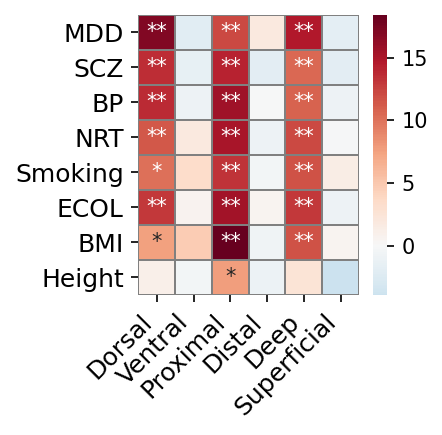

In [6]:
stats_list = ["ctrl_zscore", "ctrl_pval", "tstats"]
dict_df_stats = {stats: dict() for stats in stats_list}

spatial_cols = [
    "spatial_dorsal",
    "spatial_ventral",
    "spatial_proximal",
    "spatial_distal",
    "spatial_deep",
    "spatial_superficial",
]
for stats in stats_list:
    dict_df_stats[stats] = []
    for trait in TRAIT_LIST:
        df_tmp = dict_reg_rls[trait]
        df_tmp = df_tmp[[col for col in df_tmp.columns if col.endswith(stats)]].rename(
            columns=lambda col: col[: -len(stats) - 1]
        )
        dict_df_stats[stats].append(df_tmp)
    dict_df_stats[stats] = pd.concat(dict_df_stats[stats])

    dict_df_stats[stats] = dict_df_stats[stats][spatial_cols]


def pval2str(p_):
    if p_ > 0.05:
        return ""
    elif p_ > 0.005:
        return "*"
    else:
        return "**"


fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
df_plot = dict_df_stats["tstats"]
df_plot_annot = dict_df_stats["ctrl_pval"].applymap(pval2str)
h = sns.heatmap(
    df_plot.rename(index=DICT_TRAIT_CODE, columns=lambda x: x[8:].capitalize()),
    annot=df_plot_annot,
    linewidths=0.2,
    linecolor="gray",
    fmt="s",
    cmap="RdBu_r",
    center=0,
    ax=ax,
    annot_kws={"size": 10},
)
h.set_xticklabels(h.get_xticklabels(), rotation=45, fontsize=12, ha="right")
h.set_yticklabels(h.get_yticklabels(), fontsize=12)

plt.tight_layout()

In [7]:
adata = sc.read_h5ad(join(DATA_PATH, "single_cell_data/zeisel_2015/expr.h5ad"))
adata = adata[adata.obs["level2class"].isin(["CA1Pyr1", "CA1Pyr2"])].copy()

# load trait scores
for trait in TRAIT_LIST + spatial_cols:

    df_trait_score = pd.read_csv(
        join(SCORE_PATH, f"{trait}.score.gz"),
        sep="\t",
        index_col=0,
    )
    adata.obs[trait] = df_trait_score["norm_score"].reindex(adata.obs.index)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [8]:
dict_ys = dict()
for col in ["dorsal", "proximal", "ventral", "distal", "deep", "superficial"]:
    q = pd.qcut(adata.obs[f"spatial_{col}"], q=5)

    dict_ys[col] = {trait: [] for trait in TRAIT_LIST}
    for interval in q.cat.categories:
        interval_cell_index = interval == q
        for trait in TRAIT_LIST:
            dict_ys[col][trait].append(np.mean(adata.obs[trait][interval_cell_index]))

In [9]:
df_pval = dict_df_stats["ctrl_pval"].copy()
df_pval.columns.name = "Trait"
df_varexp = pd.DataFrame(index=df_pval.index, columns=df_pval.columns)


def style_font(x):
    str_x = f"{x:.2g}"
    if x < 0.005:
        return "(*)" + str_x
    else:
        return str_x


import statsmodels.api as sm

proximal_r2 = []
joint_r2 = []
for trait in df_varexp.index:
    for spatial_col in df_varexp.columns:
        rls = sm.OLS(adata.obs[trait], sm.add_constant(adata.obs[spatial_col])).fit()
        df_varexp.loc[trait, spatial_col] = rls.rsquared

df_pval = df_pval.rename(
    index=DICT_TRAIT_CODE, columns=lambda x: x[8:].capitalize()
).applymap(lambda x: style_font(x))

df_varexp = df_varexp.rename(
    index=DICT_TRAIT_CODE, columns=lambda x: x[8:].capitalize()
).applymap(lambda x: f"{x:.3f}")

df_pval.columns = [col + ".P" for col in df_pval.columns]
df_varexp.columns = [col + ".Var" for col in df_varexp.columns]

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
display(pd.concat([df_pval, df_varexp], axis=1)[list(interleave([df_pval, df_varexp]))])

,Dorsal.P,Dorsal.Var,Ventral.P,Ventral.Var,Proximal.P,Proximal.Var,Distal.P,Distal.Var,Deep.P,Deep.Var,Superficial.P,Superficial.Var
MDD,(*)0.001,0.260,0.75,0.005,(*)0.002,0.152,0.2,0.004,(*)0.001,0.208,0.8,0.004
SCZ,(*)0.001,0.184,0.68,0.003,(*)0.001,0.196,0.81,0.004,(*)0.001,0.119,0.83,0.004
BP,(*)0.001,0.186,0.63,0.001,(*)0.001,0.227,0.52,0.000,(*)0.001,0.125,0.66,0.001
NRT,(*)0.002,0.137,0.28,0.004,(*)0.001,0.217,0.64,0.001,(*)0.001,0.150,0.52,0.000
Smoking,0.007,0.110,0.17,0.014,(*)0.001,0.177,0.55,0.000,(*)0.001,0.142,0.26,0.002
ECOL,(*)0.001,0.170,0.41,0.000,(*)0.001,0.225,0.4,0.000,(*)0.001,0.169,0.66,0.001
BMI,0.019,0.064,0.073,0.026,(*)0.001,0.292,0.63,0.001,(*)0.001,0.143,0.41,0.000
Height,0.37,0.002,0.54,0.000,0.006,0.066,0.71,0.001,0.2,0.007,0.98,0.019


# Main figure
**NOTE**: we only show the proximal (first sub-figure) in the paper

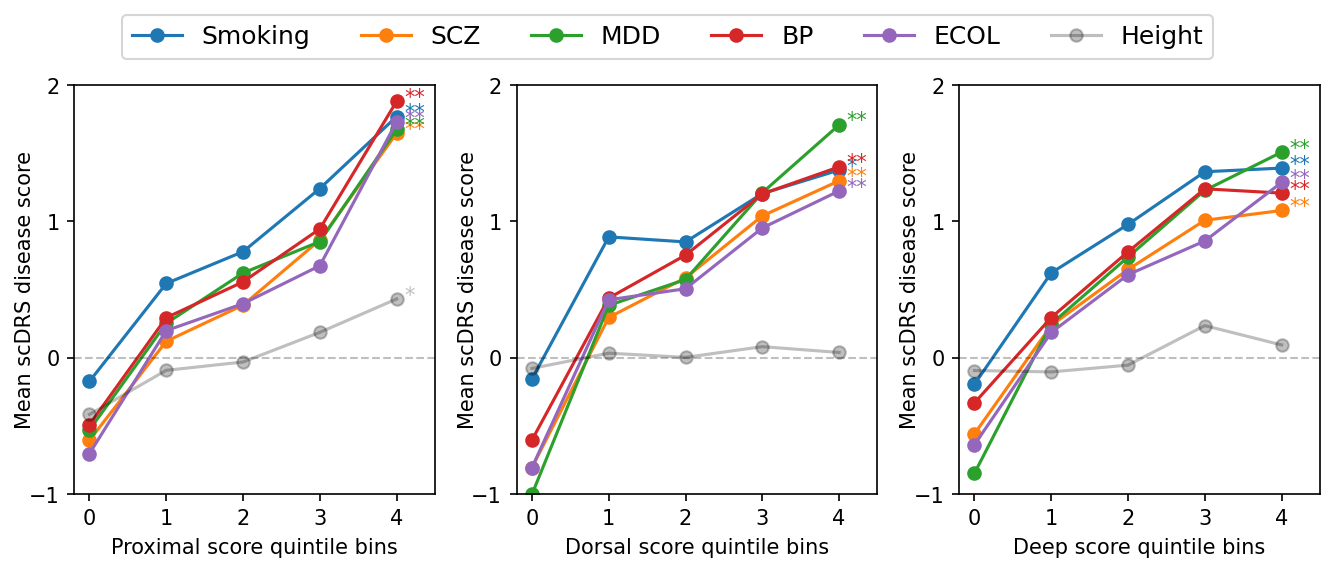

In [11]:
df_plot_annot = dict_df_stats["ctrl_pval"].applymap(pval2str)
color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
""

fig, axes = plt.subplots(figsize=(9, 3.5), ncols=3, dpi=150)
for i_col, col in enumerate(["proximal", "dorsal", "deep"]):
    ax = axes[i_col]
    for i_trait, trait in enumerate(
        [
            "UKB_460K.cov_SMOKING_STATUS",
            "PASS_Schizophrenia_Pardinas2018",
            "PASS_MDD_Howard2019",
            "PASS_BIP_Mullins2021",
            "UKB_460K.cov_EDU_COLLEGE",
            "UKB_460K.body_HEIGHTz",
        ]
    ):
        label = DICT_TRAIT_CODE[trait]
        if trait != "UKB_460K.body_HEIGHTz":
            color = color_list[i_trait]
            ax.plot(
                dict_ys[col][trait],
                "o-",
                label=label,
                color=color_list[i_trait],
            )
            ax.annotate(
                df_plot_annot.loc[trait, f"spatial_{col}"],
                xy=(4.1, dict_ys[col][trait][-1]),
                xycoords="data",
                xytext=(0, -1),
                textcoords="offset points",
                color=color_list[i_trait],
            )
        else:
            ax.plot(dict_ys[col][trait], "o-", label=label, color="k", alpha=0.25)
            ax.annotate(
                df_plot_annot.loc[trait, f"spatial_{col}"],
                xy=(4.1, dict_ys[col][trait][-1]),
                xycoords="data",
                xytext=(0, -1),
                textcoords="offset points",
                color="k",
                alpha=0.25,
            )

        ax.set_xticks(np.arange(5))
        ax.set_xlim(-0.5, 4.8)

    ax.set_xlabel(f"{col.capitalize()} score quintile bins")
    ax.grid(False)
    ax.axhline(y=0, ls="--", color="k", lw=1, alpha=0.25)

    ax.set_ylabel("Mean scDRS disease score", labelpad=-3)

    ax.set_xlim(-0.2, 4.5)
    ax.set_ylim(-1, 2.0)
    ax.set_yticks([-1, 0, 1, 2])

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, loc="upper center", ncol=6, fontsize=12, bbox_to_anchor=(0.5, 1.1)
)
plt.tight_layout()

In [12]:
adata_ca1 = adata.copy()
sc.pp.filter_cells(adata_ca1, min_genes=0)
sc.pp.filter_genes(adata_ca1, min_cells=1)
sc.pp.normalize_total(adata_ca1, target_sum=1e4)
sc.pp.log1p(adata_ca1)

sc.pp.highly_variable_genes(adata_ca1, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_ca1 = adata_ca1[:, adata_ca1.var.highly_variable]
sc.pp.scale(adata_ca1, max_value=10)
sc.tl.pca(adata_ca1, svd_solver="arpack")

sc.pp.neighbors(adata_ca1, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_ca1, n_components=2)

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


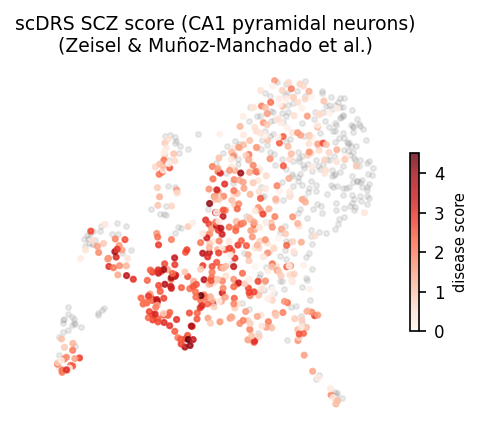

In [13]:
fig, ax = plt.subplots(figsize=(3.2, 3), dpi=150)
positive_index = adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"] > 0
negative_index = adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"] <= 0

plt.scatter(
    adata_ca1.obsm["X_umap"][negative_index, 0],
    adata_ca1.obsm["X_umap"][negative_index, 1],
    color="gray",
    vmin=0,
    vmax=4,
    s=6,
    alpha=0.15,
)

plt.scatter(
    adata_ca1.obsm["X_umap"][positive_index, 0],
    adata_ca1.obsm["X_umap"][positive_index, 1],
    c=adata_ca1.obs["PASS_Schizophrenia_Pardinas2018"][positive_index],
    cmap="Reds",
    vmin=0,
    vmax=4.5,
    s=6,
    alpha=0.8,
)

cbar = plt.colorbar(
    ticks=np.arange(5),
    shrink=0.5,
)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(label="disease score", size=7)


ax.grid(False)
ax.axis("off")
plt.xticks([])
plt.yticks([])
plt.title(
    "scDRS SCZ score (CA1 pyramidal neurons)\n(Zeisel & Muñoz-Manchado et al.)",
    fontsize=9,
)
plt.tight_layout()

<ipython-input-14-f4b091965bd2>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


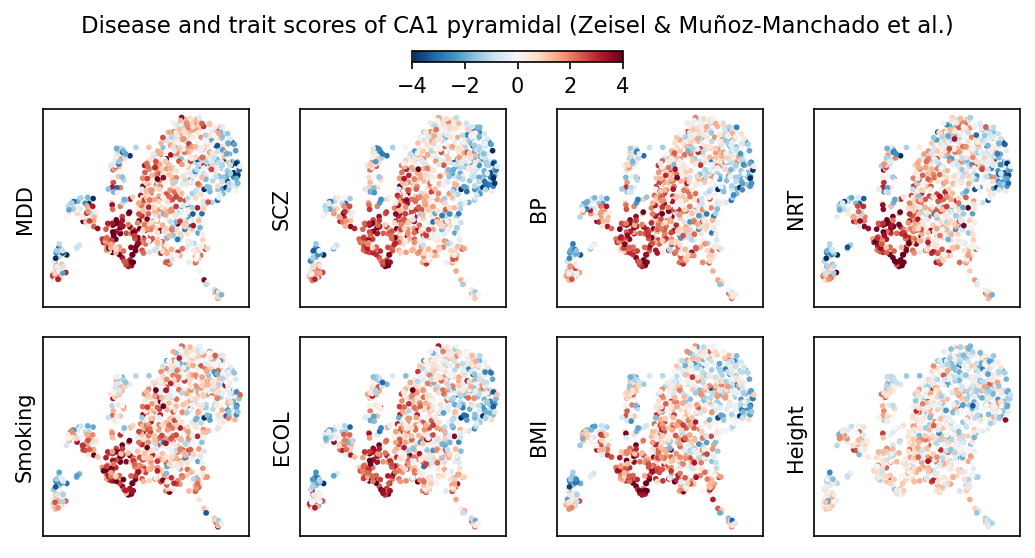

In [14]:
fig, ax = plt.subplots(figsize=(7, 3.5), nrows=2, ncols=4, dpi=150)
ax = ax.flatten()
for i, trait in enumerate(TRAIT_LIST):

    scatter = ax[i].scatter(
        adata_ca1.obsm["X_umap"][:, 0],
        adata_ca1.obsm["X_umap"][:, 1],
        c=adata_ca1.obs[trait],
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
        s=3,
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(DICT_TRAIT_CODE[trait], fontsize=10)
plt.suptitle(
    "Disease and trait scores of CA1 pyramidal (Zeisel & Muñoz-Manchado et al.)",
    fontsize=11,
    y=1.05,
)
cbar_ax = fig.add_axes([0.4, 0.96, 0.2, 0.02])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(np.arange(-4, 5, 2))

plt.tight_layout()

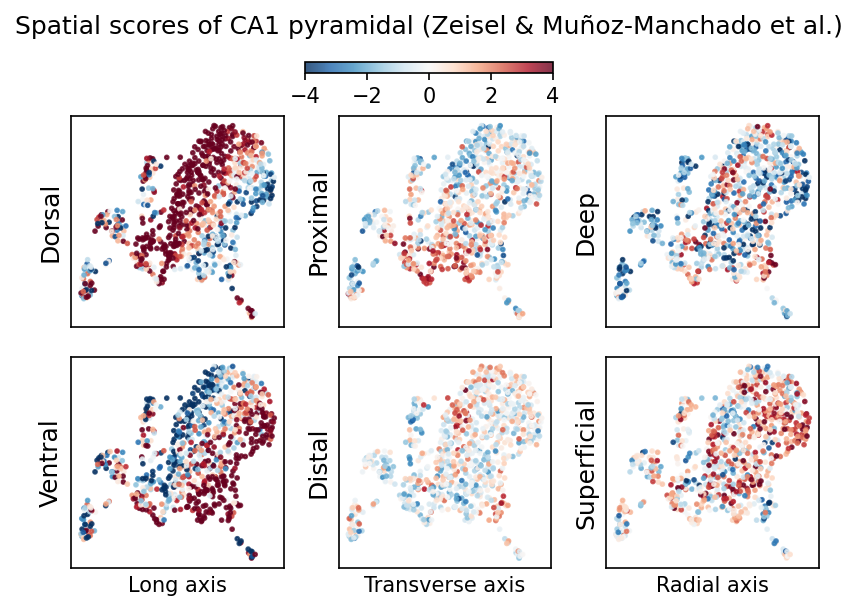

In [15]:
sc.tl.umap(adata_ca1, n_components=2)

fig, ax = plt.subplots(figsize=(5.5, 3.5), nrows=2, ncols=3, dpi=150)
ax = ax.flatten()
for i, col in enumerate(
    ["dorsal", "proximal", "deep", "ventral", "distal", "superficial"]
):
    scatter = ax.flatten()[i].scatter(
        adata_ca1.obsm["X_umap"][:, 0],
        adata_ca1.obsm["X_umap"][:, 1],
        c=adata_ca1.obs[f"spatial_{col}"],
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
        s=3,
        alpha=0.8,
    )
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylabel(col.capitalize(), fontsize=12)
ax[3].set_xlabel("Long axis")
ax[4].set_xlabel("Transverse axis")
ax[5].set_xlabel("Radial axis")

plt.tight_layout()
plt.suptitle(
    f"Spatial scores of CA1 pyramidal (Zeisel & Muñoz-Manchado et al.)",
    y=1.15,
    fontsize=12,
)
cbar_ax = fig.add_axes([0.35, 1.04, 0.3, 0.02])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation="horizontal")
cbar.set_ticks(np.arange(-4, 5, 2))